## Feature Extraction and Similar Search using Dato's Graphlab Create

In this example, we will perform feature extraction on a group of retail furniture pictures. Then we will perform nearest neighbors to yeild the closest similar product. In my other similar search example, located <a href="https://nbviewer.jupyter.org/github/WittyAgnomen/sim-search/blob/master/Sim_search.ipynb#" target="_blank">here</a>, we used caffe to perform the feature extraction. In this example, we use Dato's feature extraction tool, which doesn't allow as much freedom as caffe, but is very easy to use.

### Getting Started

We will begin by setting up our enviroment and storing our images. At the moment I will be using roughly 3600 images with some having multiple duplications. In the future, I will make the pictures available, but at the moment you could scrape your own images and follow along.

In [1]:
import graphlab as gl

2016-03-11 20:27:20,581 [WARNING] root, 63: sklearn version 0.14.1 is not supported. Minimum required version: 0.15. sklearn support will be disabled.
2016-03-11 20:27:20,790 [WARNING] root, 82: nltk version 2.0.4 is not supported. Minimum required version: 3.0. nltk support will be disabled.


In [2]:
#path to photos
path2pic='fpics/'
#function to store photos in an sframe
sa=gl.image_analysis.load_images(path2pic, "auto", with_path=True)
#show head of sframe
sa.head(5)

2016-03-11 20:27:22,268 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.4 started. Logging: /tmp/graphlab_server_1457756841.log


This non-commercial license of GraphLab Create is assigned to Skorupry@uw.edu and will expire on December 17, 2016. For commercial licensing options, visit https://dato.com/buy/.


path,image
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/baxton- ...,Height: 489 Width: 400
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/inga- ...,Height: 367 Width: 300
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/abig ...,Height: 489 Width: 400
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/geov ...,Height: 489 Width: 400
/home/ryan/Dato_Proj/Macy/macy_furn/fpics ...,Height: 489 Width: 400


#### Understanding the image loading function
The function takes the path to the folder where the images are located. Auto refers to the function automatcially choosing what type of image it is. You can set it manually to png or jpg. With 'path equal to true' will deliever us a path with the file name. We want this so we can recover the images later.

In [3]:
# Create a DeepFeatureExtractorObject
#If `model='auto'` is used, an appropriate model is chosen from a collection 
#of pre-trained models hosted by Dato.
extractor = gl.feature_engineering.DeepFeatureExtractor(features = 'image',model='auto')

# Fit the encoder for a given dataset.
extractor = extractor.fit(sa)

# Return the model used for the deep feature extraction.
extracted_model = extractor['model']

Downloading http://s3.amazonaws.com/dato-datasets/deeplearning/imagenet_model_iter45/dir_archive.ini to /var/tmp/graphlab-ryan/10304/d3323e95-1c7e-4987-90af-07debc10f101.ini

Downloading http://s3.amazonaws.com/dato-datasets/deeplearning/imagenet_model_iter45/objects.bin to /var/tmp/graphlab-ryan/10304/f1d9c9bf-0d1a-4e5e-a499-9427b0660160.bin

#### Understanding deep feature extraction with graphlab

Once a DeepFeatureExtractor object is constructed, it must first be fitted and then the transform function can be called to extract features. 

The deep featue extractor function takes an input dataset, propagates each example through the network, and returns an SArray of dense feature vectors, each of which is the concatenation of all the hidden unit values at layer[layer_id]. 

Since we are are using images, model equals auto uses a pre-trained model for ImageNet, as described by Alex Krizhevsky et. al. is avaliable for use at “http://s3.amazonaws.com/dato-datasets/deeplearning/imagenet_model_iter45”.

Now we can extract the features for our images.

In [5]:
# Extract features
features_sf = extractor.transform(sa)

# View extracted features sframe
features_sf

Images being resized.

path,image,deep_features.image
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/baxton- ...,Height: 489 Width: 400,"[0.238354921341, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/inga- ...,Height: 367 Width: 300,"[0.0, 0.0,0.147137224674, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/abig ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0,0.0735867619514, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/geov ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0,0.918317556381, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/geov ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0,0.726919412613, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/simpli- ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/simpli- ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/baxton- ...,Height: 400 Width: 328,"[0.0, 0.0608259439468,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/home/ryan/Dato_Proj/Macy/macy_furn/fpics/liam- ...,Height: 489 Width: 400,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."


#### Getting rid of duplicate photos 

After we get rid of multiple photos we are left with 1602 unique images.

In [7]:
#Getting rid of duplicate photos 
features_sf=features_sf.groupby('deep_features.image',{'path':gl.aggregate.SELECT_ONE('path')})

#print head of sf
features_sf

deep_features.image,path
"[0.0, 0.0, 0.0, 0.0,3.13493990898, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics ...
"[0.0, 0.0, 0.0, 0.0,2.13959622383, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/chloe- ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/simpli- ...
"[0.0, 0.0, 0.0, 0.0,1.50201153755, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/teddy- ...
"[0.0, 1.04328107834, 0.0,0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/ains ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/kory ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 2.49341630936, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/elat ...
"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ...",/home/ryan/Dato_Proj/Macy/macy_furn/fpics/jla- ...


#### Getting similar products using nearest neighbor

As we can see our deep features column is made up of vectors where each vector has 4096 features. These features are rathr sparse. Because of this fact, we will use a cosine distance as oposed to euclidian in our model.

In [8]:
#set up nn model
model = gl.nearest_neighbors.create(features_sf,features=['deep_features.image'], distance='cosine')

#model summary
model.summary()

Starting brute force nearest neighbors model training.

Class                         : NearestNeighborsModel

Attributes
----------
Method                        : brute_force
Number of distance components : 1
Number of examples            : 1602
Number of feature columns     : 1
Number of unpacked features   : 4096
Total training time (seconds) : 1.3388



#### Next

We will run nearest nighbor with k=5. Thus getting 4 nighbors because the model returns itself as the closest neighbor.

In [9]:
#add id to match images
features_sf=features_sf.add_row_number()

#create sframe for nn model
knn = model.query(features_sf, k=5)

#call nn model
knn

Starting blockwise querying.

max rows per data block: 7668

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1602         | 320400  | 12.4844     | 638.953ms    |

| Done         | 2566404 | 100         | 656.26ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,0,0.0,1
0,1560,0.100960225707,2
0,1232,0.107696802493,3
0,1491,0.13829849253,4
0,1061,0.158994253981,5
1,1,0.0,1
1,1386,0.138628010574,2
1,45,0.139696972699,3
1,521,0.144613265272,4
1,1119,0.150133559611,5


#### Cleaning and creating a interpretable sframe for the results

Below we run code to create a sframe where we can retrieve the images.

In [10]:
#create sframe that has images names in for nn model
features_sf=features_sf.rename({'id':'query_label'})
results=knn.join(features_sf, on='query_label', how='left')
results=results.rename({'path':'product'})
features_sf=features_sf.rename({'query_label':'reference_label'})
results=results.join(features_sf, on='reference_label', how='left')
results=results.rename({'path':'similar_product'})
results.remove_columns(['deep_features.image.1','deep_features.image'])
results['product']=results['product'].apply(lambda x: x.split('/')[-1])
results['similar_product']=results['similar_product'].apply(lambda x: x.split('/')[-1])
results


query_label,reference_label,distance,rank,product,similar_product
0,0,0.0,1,michelle-fabric-living-room-chair?ID=792838& ...,michelle-fabric-living-room-chair?ID=792838& ...
0,1560,0.100960225707,2,michelle-fabric-living-room-chair?ID=792838& ...,michelle-fabric-loveseat?ID=792837&CategoryID= ...
0,1232,0.107696802493,3,michelle-fabric-living-room-chair?ID=792838& ...,michelle-fabric-living-room-chair-custom-col ...
0,1491,0.13829849253,4,michelle-fabric-living-room-chair?ID=792838& ...,michelle-fabric-sofa?ID=792836&CategoryID=3531 ...
0,1061,0.158994253981,5,michelle-fabric-living-room-chair?ID=792838& ...,blair-leather-loveseat?ID=255919&CategoryID=35 ...
1,1,0.0,1,chloe-velvet-tufted-loveseat?ID=351408&Categor ...,chloe-velvet-tufted-loveseat?ID=351408&Categor ...
1,1386,0.138628010574,2,chloe-velvet-tufted-loveseat?ID=351408&Categor ...,milan-leather-loveseat?ID=251085&CategoryID=35 ...
1,45,0.139696972699,3,chloe-velvet-tufted-loveseat?ID=351408&Categor ...,clare-fabric-loveseat-60w-x-37d-x-37h?ID=67257 ...
1,521,0.144613265272,4,chloe-velvet-tufted-loveseat?ID=351408&Categor ...,braylei-chaise?ID=2138580&CategoryID=35319&Lin ...
1,1119,0.150133559611,5,chloe-velvet-tufted-loveseat?ID=351408&Categor ...,keaton-leather-sofa?ID=2471117&CategoryID=7127 ...


#### Evaluating the results

This first example is for query label id 1 seen above and looks rather good. The top pic is the main product and the ones below are the similar products.

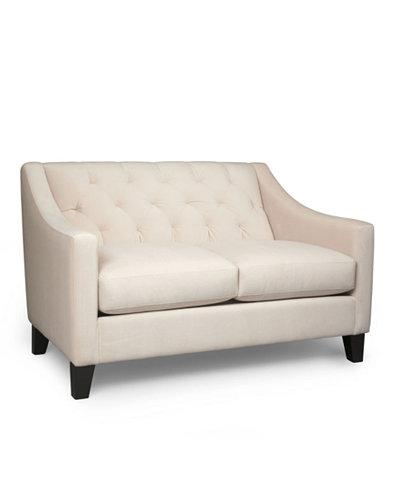

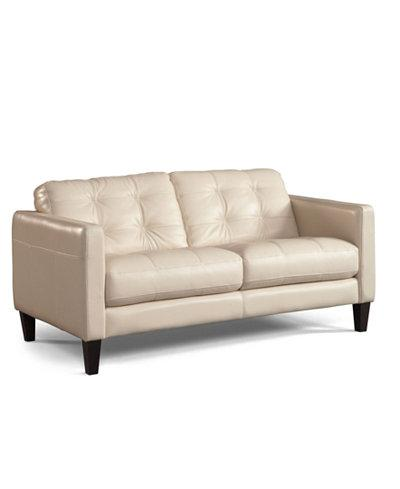

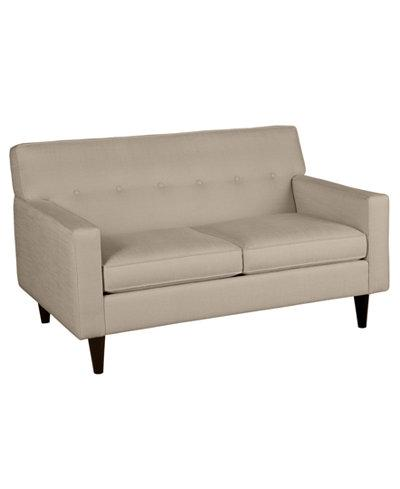

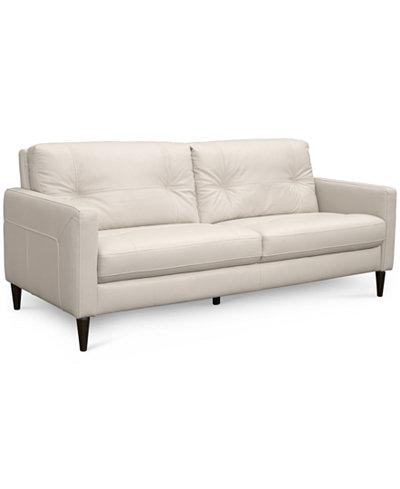

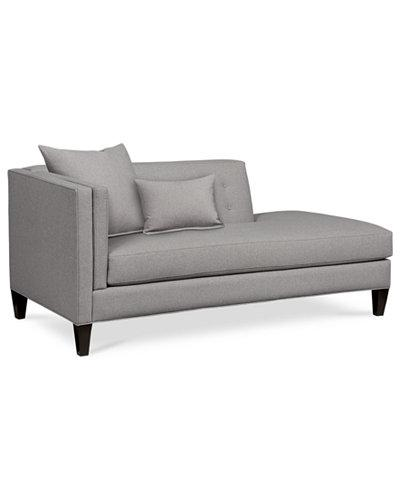

In [19]:
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import display
display(Image("expics/ex1/chloe-velvet-tufted-loveseat?ID=351408&CategoryID=35319.jpg", width=100, height=100),
Image("expics/ex1/milan-leather-loveseat?ID=251085&CategoryID=35319.jpg", width=100, height=100),
Image("expics/ex1/clare-fabric-loveseat-60w-x-37d-x-37h?ID=672573&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex1/keaton-leather-sofa?ID=2471117&CategoryID=35419.jpg", width=100, height=100),
Image("expics/ex1/braylei-chaise?ID=2138580&CategoryID=35319&LinkType=.jpg", width=100, height=100))

#### A second example

The second ecample is for query id 700. Using code: <span style="background-color: #BCC6CC">results.filter_by(700, 'query_label')</span> As we can see this example looks rather good as well.

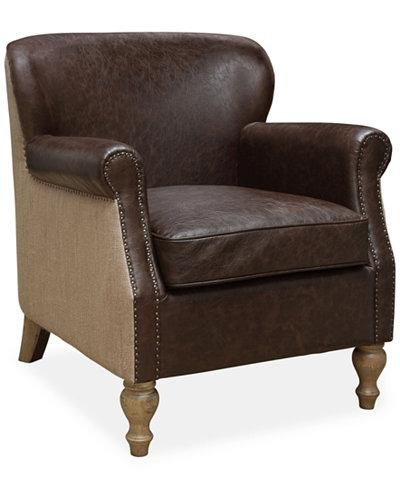

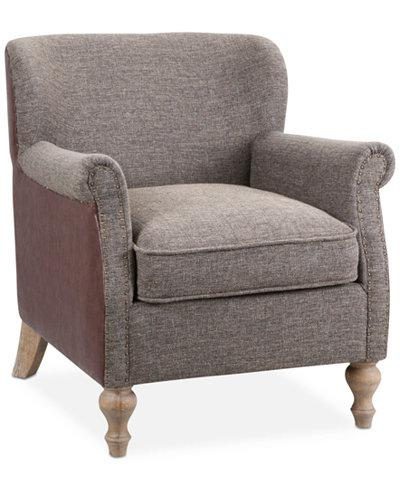

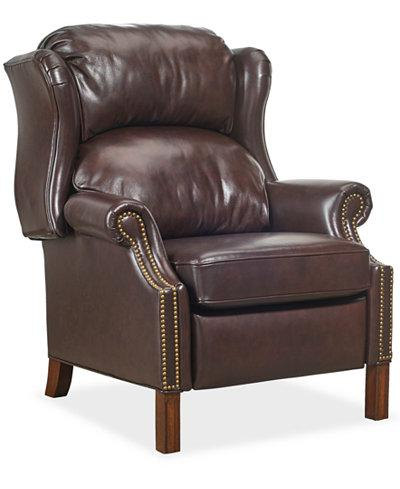

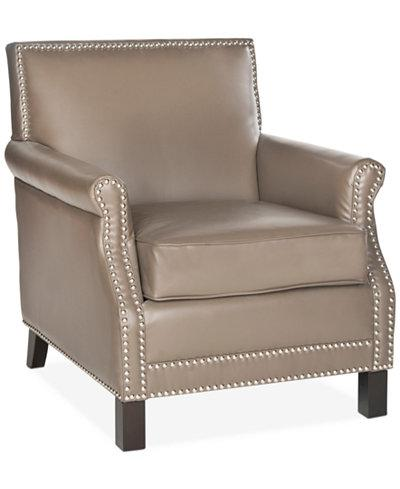

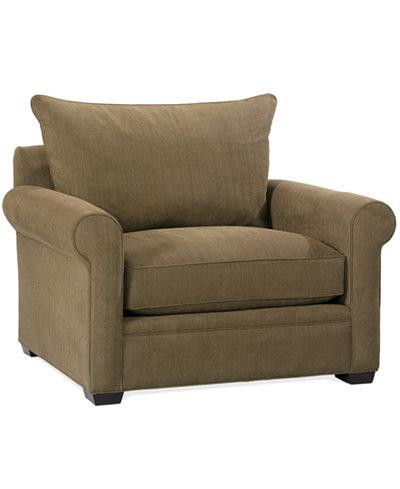

In [20]:
display(Image("expics/ex700/jla-chelsie-faux-leather-fabric-accent-chair-direct-ship?ID=1791052&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex700/jla-chelsie-fabric-faux-leather-accent-chair-direct-ship?ID=1658710&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex700/dahlia-leather-recliner?ID=2366491&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex700/safavieh-benson-leather-accent-chair-direct-ship?ID=1896396&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex700/dial-fabric-microfiber-living-room-chair?ID=315464&CategoryID=35319&LinkType=.jpg", width=100, height=100))

#### Caveat

So far the results have been good. But there is a caveat. If the query image does not represent the product well, meaning there may be other products in the image, the results are not so great. Below is an example for querry id 1500; the code used is: <span style="background-color: #BCC6CC">results.filter_by(1500, 'query_label')</span>. 

As we can, the product is a coffee table, but the product image also has a couch in it. Therefore, are results are rather poor. One easy way to fix this would be to use product category as a feature in the nn model. If we gave the product category feature a higher weight than the extracted image features, we would be more likely to get other coffee tables as neighbors. 

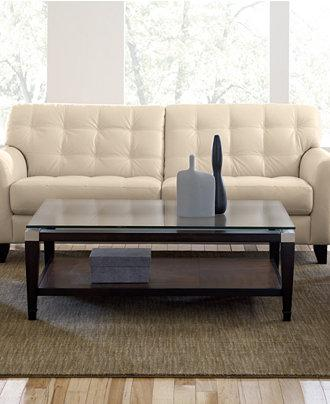

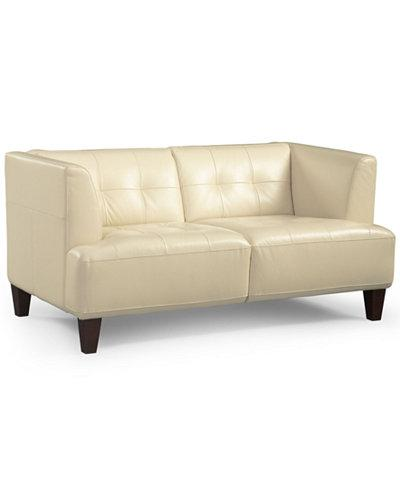

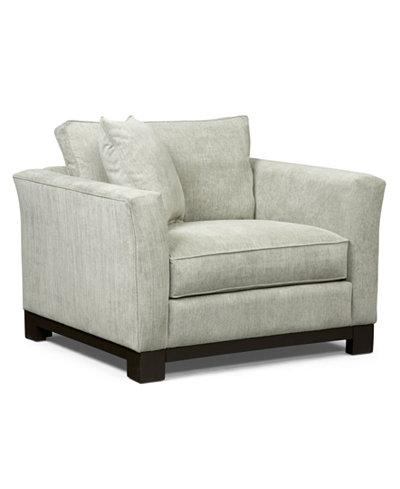

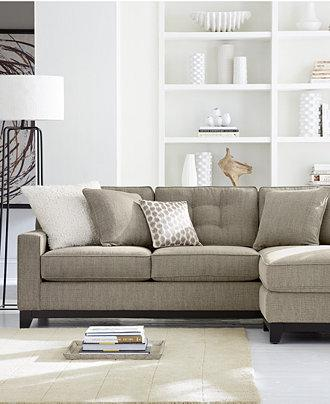

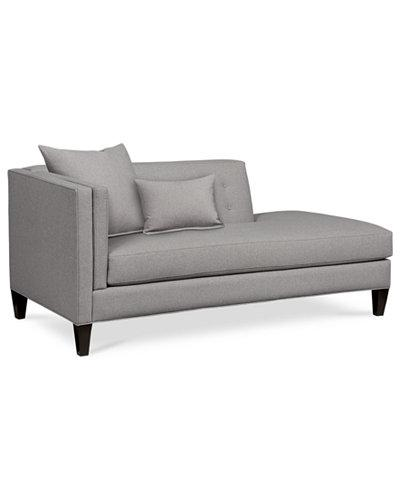

In [23]:
display(Image("expics/ex1500/silverado-glass-top-table-collection?ID=314860&CategoryID=69950&LinkType=.jpg", width=100, height=100),
Image("expics/ex1500/alessia-leather-loveseat?ID=475434&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex1500/kenton-fabric-living-room-chair?ID=683439&CategoryID=35319&LinkType=.jpg", width=100, height=100),
Image("expics/ex1500/clarke-fabric-sectional-sofa-living-room-furniture-sets-pieces-only-at-macys?ID=827903&CategoryID=69950.jpg", width=100, height=100),
Image("expics/ex1500/braylei-chaise?ID=2138580&CategoryID=35319&LinkType=.jpg", width=100, height=100))